In [1]:
%matplotlib widget

#from IPython import display
from base64 import b64decode
from pacti import write_contracts_to_file
from pacti.terms.polyhedra import *
from pacti.iocontract import IoContract, Var
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import patches
import pdb
from matplotlib.collections import PatchCollection
from contract_utils import *

## Thermal viewpoint modeling

Except for TCM, all other tasks have the same qualitative thermal impact: the spacecraft's thrusters quickly reach their coldest temperature since they are off and have no thermal insulation or significant thermal capacity. Consequently, we define a common contract template for modeling the cooling impact in a way that is independent of the scheduled task duration.


In [2]:
def COOLING_thermal(s: int) -> PolyhedralContract:
    spec = PolyhedralContract.from_string(
        input_vars=[
            f"temp{s}_entry",   # initial thrusters temperature
        ],
        output_vars=[
            f"temp{s}_exit",    # final thrusters temperature
        ],
        assumptions=[
            # Upper-bound thruster temperature
            f"temp{s}_entry <= 100",
            # lower-bound thruster temperature
            f"-temp{s}_entry <= 0",
        ],
        guarantees=[
            # thrusters quickly cool down to their lowest temperature
            f" temp{s}_exit = 0",
        ],
    )
    return spec

### CHARGING Task

Objective: charge the spacecraft battery

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint according to the cooling impact defined above.


In [3]:
charging1_thermal = COOLING_thermal(s=2)
print(f"Contract charging1_thermal:\n\n{charging1_thermal}")

Contract charging1_thermal:

InVars: [temp2_entry]
OutVars:[temp2_exit]
A: [
  temp2_entry <= 100.0
  -temp2_entry <= 0.0
]
G: [
  temp2_exit = 0.0
]


### DSN Task

Objective: downlink science data to Earth.

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint according to the cooling impact defined above.


In [4]:
dsn1_thermal = COOLING_thermal(s=1)
print(f"Contract dsn1_thermal:\n\n{dsn1_thermal}")

Contract dsn1_thermal:

InVars: [temp1_entry]
OutVars:[temp1_exit]
A: [
  temp1_entry <= 100.0
  -temp1_entry <= 0.0
]
G: [
  temp1_exit = 0.0
]


### SBO Task (Small body observations)

Objective: Acquire small body observations (science data & navigation)

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint according to the cooling impact defined above.


In [5]:
sbo1_thermal = COOLING_thermal(s=3)
print(f"Contract sbo1_thermal:\n\n{sbo1_thermal}")

Contract sbo1_thermal:

InVars: [temp3_entry]
OutVars:[temp3_exit]
A: [
  temp3_entry <= 100.0
  -temp3_entry <= 0.0
]
G: [
  temp3_exit = 0.0
]


### TCM Task (Perform a Trajectory Correction Maneuver)

Objective: Perform a delta-V maneuver to bring the spacecraft trajectory closer to that of the small body.

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with impacts that are linear with the duration of the task:

- Thermal:
  - the thrusters must be heated before firing them, thereby discharging the battery proportionally to a consumption rate.
  - the deltaV maneuver fires the spacecraft thrusters, keeping them from cooling.

#### TCM Heating SubTask


Contract tcm1_heating_thermal:

InVars: [temp4_entry, duration_tcm_heating4]
OutVars:[temp4_exit]
A: [
  -duration_tcm_heating4 <= 0.0
  4.7 duration_tcm_heating4 + temp4_entry <= 100.0
  -temp4_entry <= 0.0
]
G: [
  -4.7 duration_tcm_heating4 - temp4_entry + temp4_exit <= 0.0
  4.5 duration_tcm_heating4 + temp4_entry - temp4_exit <= 0.0
]


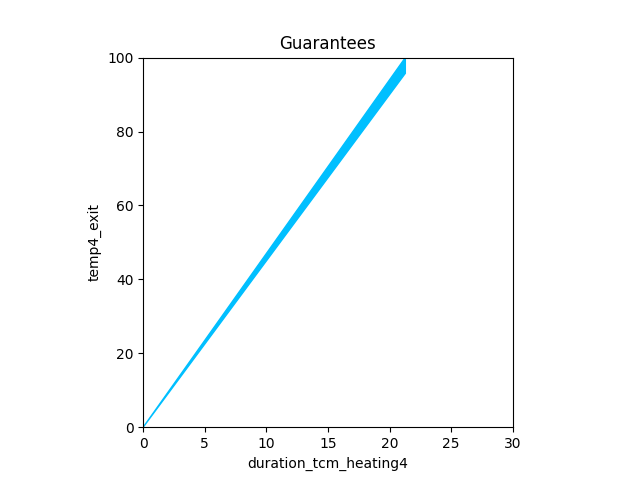

In [6]:
def TCM_heating_thermal(s: int, heating_rate: tuple[float, float]) -> PolyhedralContract:
    spec = PolyhedralContract.from_string(
        input_vars=[
            f"temp{s}_entry",           # initial thrusters temperature
            f"duration_tcm_heating{s}", # allocation variable for TCM heating duration
        ],
        output_vars=[
            f"temp{s}_exit",            # final thrusters temperature
        ],
        assumptions=[
            # Task has a positive scheduled duration
            f"-duration_tcm_heating{s} <= 0",
            # thursters should not overheat
            f"temp{s}_entry + {heating_rate[1]}*duration_tcm_heating{s} <= 100",
            # lower-bound thruster temperature
            f"-temp{s}_entry <= 0",
        ],
        guarantees=[
            # duration*heating_rate(min) <= temp{exit} - temp{entry} <= duration*heating_rate(max)
            f" temp{s}_exit - temp{s}_entry - {heating_rate[1]}*duration_tcm_heating{s} <= 0",
            f"-temp{s}_exit + temp{s}_entry + {heating_rate[0]}*duration_tcm_heating{s} <= 0",
            # Upper-bound thruster temperature
            f"temp{s}_exit <= 100",
        ],
    )
    return spec

tcm1_heating_thermal = TCM_heating_thermal(s=4, heating_rate=(4.5, 4.7))
print(f"Contract tcm1_heating_thermal:\n\n{tcm1_heating_thermal}")

_ = plot_guarantees(
    contract=tcm1_heating_thermal,
    x_var=Var("duration_tcm_heating4"),
    y_var=Var("temp4_exit"),
    var_values={
        Var("temp4_entry"): 0,
    },
    x_lims=(0, 30),
    y_lims=(0, 100),
)

#### TCM DeltaV SubTask


Contract tcm1_deltav_thermal:

InVars: [temp5_entry, duration_tcm_deltav5]
OutVars:[temp5_exit]
A: [
  -temp5_entry <= -80.0
]
G: [
  -0.2 duration_tcm_deltav5 + temp5_entry - temp5_exit <= 0.0
  0.1 duration_tcm_deltav5 - temp5_entry + temp5_exit <= 0.0
  -temp5_exit <= 0.0
]


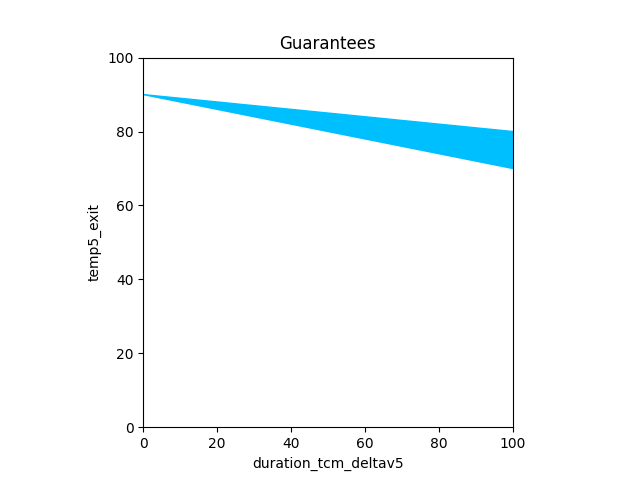

In [7]:
def TCM_deltav_thermal(s: int, cooling_rate: tuple[float, float], warm_temp: float) -> PolyhedralContract:
    spec = PolyhedralContract.from_string(
        input_vars=[
            f"temp{s}_entry",           # initial thrusters temperature
            f"duration_tcm_deltav{s}",  # allocation variable for TCM deltav duration
        ],
        output_vars=[
            f"temp{s}_exit",            # final thrusters temperature
        ],
        assumptions=[
            # thrusters are warm
            f"-temp{s}_entry <= -{warm_temp}",
        ],
        guarantees=[
            # duration*cooling_rate(min) <= temp{entry} - temp{exit} <= duration*cooling_rate(max)
            f" temp{s}_entry - temp{s}_exit - {cooling_rate[1]}*duration_tcm_deltav{s} <= 0",
            f"-temp{s}_entry + temp{s}_exit + {cooling_rate[0]}*duration_tcm_deltav{s} <= 0",
            # lower-bound thruster temperature
            f"-temp{s}_exit <= 0",
        ],
    )
    return spec

tcm1_deltav_thermal = TCM_deltav_thermal(s=5, cooling_rate=(0.1, 0.2), warm_temp=80.0)
print(f"Contract tcm1_deltav_thermal:\n\n{tcm1_deltav_thermal}")

_ = plot_guarantees(
    contract=tcm1_deltav_thermal,
    x_var=Var("duration_tcm_deltav5"),
    y_var=Var("temp5_exit"),
    var_values={
        Var("temp5_entry"): 90,
    },
    x_lims=(0, 100),
    y_lims=(0, 100),
)

#### Composing TCM SubTasks

Algebraic composition allows us to capture the requirement that a TCM Heating subtask must always precede a TCM DeltaV subtask by composing them.


In [8]:
tcm1_thermal = scenario_sequence(c1=tcm1_heating_thermal, c2=tcm1_deltav_thermal, variables=["temp"], c1index=4)
print(f"========= tcm1_thermal\n{tcm1_thermal}")

========= tcm1_thermal
InVars: [temp4_entry, duration_tcm_heating4, duration_tcm_deltav5]
OutVars:[temp5_exit, output_temp4]
A: [
  -4.5 duration_tcm_heating4 - temp4_entry <= -80.0
  -duration_tcm_heating4 <= 0.0
  4.7 duration_tcm_heating4 + temp4_entry <= 100.0
  -temp4_entry <= 0.0
]
G: [
  -4.7 duration_tcm_heating4 + output_temp4 - temp4_entry <= 0.0
  4.5 duration_tcm_heating4 - output_temp4 + temp4_entry <= 0.0
  -0.2 duration_tcm_deltav5 + output_temp4 - temp5_exit <= 0.0
  0.1 duration_tcm_deltav5 - output_temp4 + temp5_exit <= 0.0
  -temp5_exit <= 0.0
]


### Thermal Schedule Analysis

Let's consider a simple 4-step schedule of the following sequence of task instances, which we compose:

- DSN
- CHARGING
- SBO
- TCM


In [9]:
steps12 = scenario_sequence(c1=dsn1_thermal, c2=charging1_thermal, variables=["temp"], c1index=1)
print(f"---- Steps 1,2\n{steps12}")
steps12.get_variable_bounds("output_temp1")

---- Steps 1,2
InVars: [temp1_entry]
OutVars:[temp2_exit, output_temp1]
A: [
  temp1_entry <= 100.0
  -temp1_entry <= 0.0
]
G: [
  output_temp1 = 0.0
  temp2_exit = 0.0
]


(0.0, -0.0)

In [10]:
steps123 = scenario_sequence(c1=steps12, c2=sbo1_thermal, variables=["temp"], c1index=2)
print(f"---- Steps 1,2,3\n{steps123}")
print(steps123.get_variable_bounds("output_temp2"))

---- Steps 1,2,3
InVars: [temp1_entry]
OutVars:[output_temp1, temp3_exit, output_temp2]
A: [
  temp1_entry <= 100.0
  -temp1_entry <= 0.0
]
G: [
  output_temp1 = 0.0
  output_temp2 = 0.0
  temp3_exit = 0.0
]
(0.0, -0.0)


In [11]:
steps1234 = scenario_sequence(c1=steps123, c2=tcm1_thermal, variables=["temp"], c1index=3)
print(f"---- Steps 1,2,3,4\n{steps1234}")
print(steps1234.get_variable_bounds("output_temp3"))
print(steps1234.get_variable_bounds("output_temp4"))

---- Steps 1,2,3,4
InVars: [temp1_entry, duration_tcm_heating4, duration_tcm_deltav5]
OutVars:[output_temp1, output_temp2, temp5_exit, output_temp4, output_temp3]
A: [
  -4.5 duration_tcm_heating4 <= -80.0
  4.7 duration_tcm_heating4 <= 100.0
  temp1_entry <= 100.0
  -temp1_entry <= 0.0
]
G: [
  output_temp1 = 0.0
  output_temp2 = 0.0
  output_temp3 = 0.0
  -4.7 duration_tcm_heating4 - output_temp3 + output_temp4 <= 0.0
  4.5 duration_tcm_heating4 + output_temp3 - output_temp4 <= 0.0
  -0.2 duration_tcm_deltav5 + output_temp4 - temp5_exit <= 0.0
  0.1 duration_tcm_deltav5 - output_temp4 + temp5_exit <= 0.0
  -temp5_exit <= 0.0
]
(0.0, -0.0)
(80.0, 100.0)


In [12]:
scenario_thermal = steps1234.rename_variables([("temp5_exit", "output_temp5")])
print(f"scenario_power={scenario_thermal}")

scenario_power=InVars: [temp1_entry, duration_tcm_heating4, duration_tcm_deltav5]
OutVars:[output_temp1, output_temp2, output_temp4, output_temp3, output_temp5]
A: [
  -4.5 duration_tcm_heating4 <= -80.0
  4.7 duration_tcm_heating4 <= 100.0
  temp1_entry <= 100.0
  -temp1_entry <= 0.0
]
G: [
  output_temp1 = 0.0
  output_temp2 = 0.0
  output_temp3 = 0.0
  -4.7 duration_tcm_heating4 - output_temp3 + output_temp4 <= 0.0
  4.5 duration_tcm_heating4 + output_temp3 - output_temp4 <= 0.0
  -0.2 duration_tcm_deltav5 + output_temp4 - output_temp5 <= 0.0
  0.1 duration_tcm_deltav5 - output_temp4 + output_temp5 <= 0.0
  -output_temp5 <= 0.0
]


In [13]:
write_contracts_to_file(contracts=[scenario_thermal], names=["scenario_thermal"], file_name="json/scenario_thermal.json")